# **Ejercicio entregable 1**

El documento está orientado a la realización de una red DCNN que permita clasificar entre imágenes de perros y gatos.
Para ello, se han definido todos los pasos que debereís dar y la puntuación de los mismos

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#from tensorflow.keras.processing.image import ImageDataGenerator

import os

from google.colab import drive
drive.mount('/content/drive')


path_cats = "/content/drive/MyDrive/Deep Learning/Datasets/dataset_cat_dog/cat"
path_dogs = "/content/drive/MyDrive/Deep Learning/Datasets/dataset_cat_dog/dog"

Mounted at /content/drive


## Construcción del dataset

In [ ]:
def image_transformation(path,label):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (128,128))
  img = tf.cast(img, tf.float32)/255
  return (img , label)

In [ ]:
def get_dataset(batch_size=128):
  content = [(os.path.join(path_cats,name),[1,0]) for name in os.listdir(path_cats)]
  content += [(os.path.join(path_dogs,name),[0,1]) for name in os.listdir(path_dogs)]

  X_train, X_test, Y_train, Y_test = train_test_split([a for (a,_) in content],[b for (_,b) in content], test_size=0.2, random_state=23)

  train_data = tf.data.Dataset.from_tensor_slices((tf.constant(X_train), tf.constant(Y_train))).map(image_transformation, num_parallel_calls=tf.data.AUTOTUNE).cache().batch(batch_size)
  test_data = tf.data.Dataset.from_tensor_slices((tf.constant(X_test), tf.constant(Y_test))).map(image_transformation, num_parallel_calls=tf.data.AUTOTUNE).cache().batch(batch_size)

  return train_data, test_data

In [ ]:
train_data, test_data = get_dataset()

## Estructura del modelo

In [ ]:
def get_model():
  model = keras.models.Sequential()
  model.add(layers.Conv2D(16,3,activation='relu',input_shape=(128,128,3)))
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(32,3,activation='relu'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(64,3,activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(2,activation='softmax'))
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  return model

##  Model summary

In [ ]:
model = get_model()

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 63, 63, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 flatten_1 (Flatten)         (None, 50176)            

##  Callbacks

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [ ]:
reduce_lr_on_plateau = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=5)

In [ ]:
# model_checkpoint = keras.callbacks.ModelCheckpoint(filepath="./generated/model", monitor='val_accuracy', save_best_only=True, save_weights_only=False)

##  Entrenamiento

In [ ]:
history = model.fit(train_data, epochs=1000, verbose=1, validation_data=test_data, callbacks=[early_stopping, reduce_lr_on_plateau])

Epoch 1/1000
21/21 [==============================] - 443s 20s/step - loss: 0.7058 - accuracy: 0.5301 - val_loss: 0.6770 - val_accuracy: 0.6098 - lr: 0.0010
Epoch 2/1000
21/21 [==============================] - 1s 45ms/step - loss: 0.6531 - accuracy: 0.6308 - val_loss: 0.6179 - val_accuracy: 0.7043 - lr: 0.0010
Epoch 3/1000
21/21 [==============================] - 1s 42ms/step - loss: 0.5778 - accuracy: 0.7018 - val_loss: 0.5736 - val_accuracy: 0.7165 - lr: 0.0010
Epoch 4/1000
21/21 [==============================] - 1s 44ms/step - loss: 0.5153 - accuracy: 0.7452 - val_loss: 0.5449 - val_accuracy: 0.7348 - lr: 0.0010
Epoch 5/1000
21/21 [==============================] - 1s 50ms/step - loss: 0.4814 - accuracy: 0.7689 - val_loss: 0.5403 - val_accuracy: 0.7241 - lr: 0.0010
Epoch 6/1000
21/21 [==============================] - 1s 49ms/step - loss: 0.4575 - accuracy: 0.7887 - val_loss: 0.5151 - val_accuracy: 0.7470 - lr: 0.0010
Epoch 7/1000
21/21 [==============================] - 1s 43ms/s

##  Ejemplo del dataset

In [ ]:
def predict_image(model,path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3, try_recover_truncated = True)
  img = tf.image.resize(img, (128,128))
  img = tf.cast(img, tf.float32)/255
  img = tf.reshape(img, (1,128,128,3))
  prediction = model.predict(img)
  prob = prediction.max()
  return ('cat', prob) if prediction.argmax()==0 else ('dog', prob)


In [ ]:
predict_image(model,os.path.join(path_cats,'cat.jpg'))

1/1 [==============================] - 0s 390ms/step


('cat', 0.9986356)

##  Gráficas de entrenamiento y test empleando las variables accuracy y loss

##### LOSS

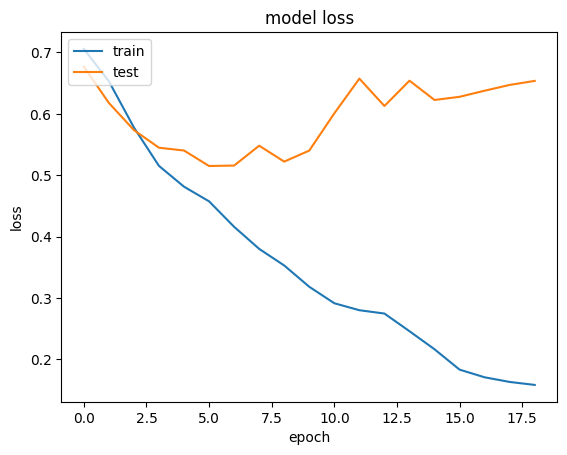

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##### ACCURACY

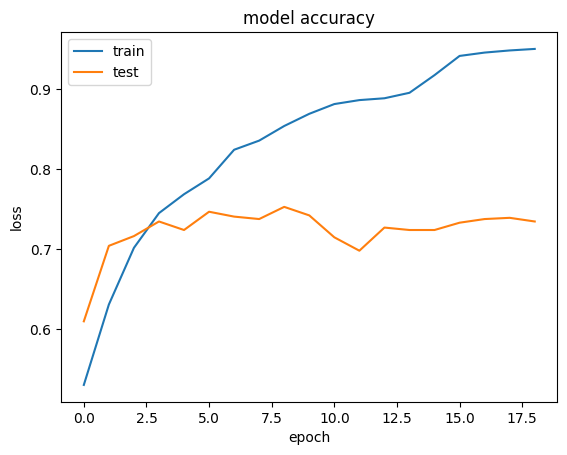

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##  Guardado del modelo

In [ ]:
path_save = "/content/drive/MyDrive/Deep Learning/Models"

model_path = os.path.join(path_save,'cat_dog')
model.save(model_path)

-